# Gender and Mean Suicide Rates in Canada
### Group 11 Final Report
##### Group Members: 
Aaron Cui (94952777)
<br>Aditya Goel (84874379)
<br>Jialu Jin (24403594)
<br>Yirui Wang (27719509)

### Introduction


Suicide is a prevalent cause of death in Canada, accounting for 1.2% of all deaths in the year 2020 (Elflein, 2020). Past research has led us to believe that there may be differences in suicide rates between men and women, therefore we are interested in further studying this phenomenon (Freeman et al., 2017). As a result, our research question for this project is: **what were the mean suicide rates of males and females in Canada between 1985 and 2013?** We will be using the "Suicide Rates Overview 1985 to 2016" (Rusty, 2018) dataset sourced from Kaggle for our analysis, focusing only on the data relevant to Canada. This dataset has 12 columns and 27820 rows. Different columns are different response variables accross the socio-economic spectrum that might affect the suicide rates globally. Finally, the number of suicides per 100,000 people (essentially the suicide rate) will be our response variable, mean the location parameter, and standard deviation the scale parameter. We decided to use mean as it gives a good sense of the center of the data while standard deviation helps us understand the spread; ultimately helping us evaluate the error in our results. 

### Methods & Results
#### Preliminary Results

In [2]:
# loading all the necessary libraries
library(infer)
library(repr)
library(tidyverse)
library(readxl)
library(digest)
library(dplyr)
library(tidymodels)
library(GGally)
library(RCurl)
library(ggplot2)
library(ggmosaic)

# setting the maximum rows to be displayed to 6
options(repr.matrix.max.rows = 6)

ERROR: Error in library(ggmosaic): there is no package called ‘ggmosaic’


We downloaded the dataset from the web and put it in our repository in the data folder.

In [3]:
# loading the data from the data folder and displaying the head (first 6 rows)
# the data was downloaded from the following link: "https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016"
suicide_data <- read.csv("https://raw.githubusercontent.com/agoel25/stat_201_group_11/main/data/master.csv")
head(suicide_data)

,country,year,sex,age,suicides_no,population,suicides.100k.pop,country.year,HDI.for.year,gdp_for_year....,gdp_per_capita....,generation
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<int>,<chr>
1,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NA,"2,156,624,900",796,Generation X
2,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NA,"2,156,624,900",796,Silent
3,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NA,"2,156,624,900",796,Generation X
4,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NA,"2,156,624,900",796,G.I. Generation
5,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NA,"2,156,624,900",796,Boomers
6,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NA,"2,156,624,900",796,G.I. Generation


We cleaned and wrangled the data by filtering only Canada and selecting "sex", "year", "age" and "suicides.100k.pop" columns. 

In [5]:
# filtering for Canada (as our question specifically focuses on Canada) and selecting the appropriate columns
suicide_sample <- suicide_data %>%
                  filter(country %in% c("Canada")) %>%
                  select(sex, year, age, suicides.100k.pop)
head(suicide_sample)

,sex,year,age,suicides.100k.pop
,<chr>,<int>,<chr>,<dbl>
1,male,1985,75+ years,28.45
2,male,1985,55-74 years,27.27
3,male,1985,25-34 years,27.00
4,male,1985,35-54 years,25.40
5,male,1985,15-24 years,25.17
6,female,1985,35-54 years,8.43


- We plot a boxplot of number of suicides per 100k population for different sex.
- We also plot a histogram of Sample distribution of number of suicides per 100k population in Canada for 2 sex groups.
- From the boxplot, we can see that the boxplots of two genders don't even overlap. Also, from the histogram, the sample distribution varies a lot for different genders. So we think this might indicate that there is a difference of the mean number of suicides per 100k population for two genders.

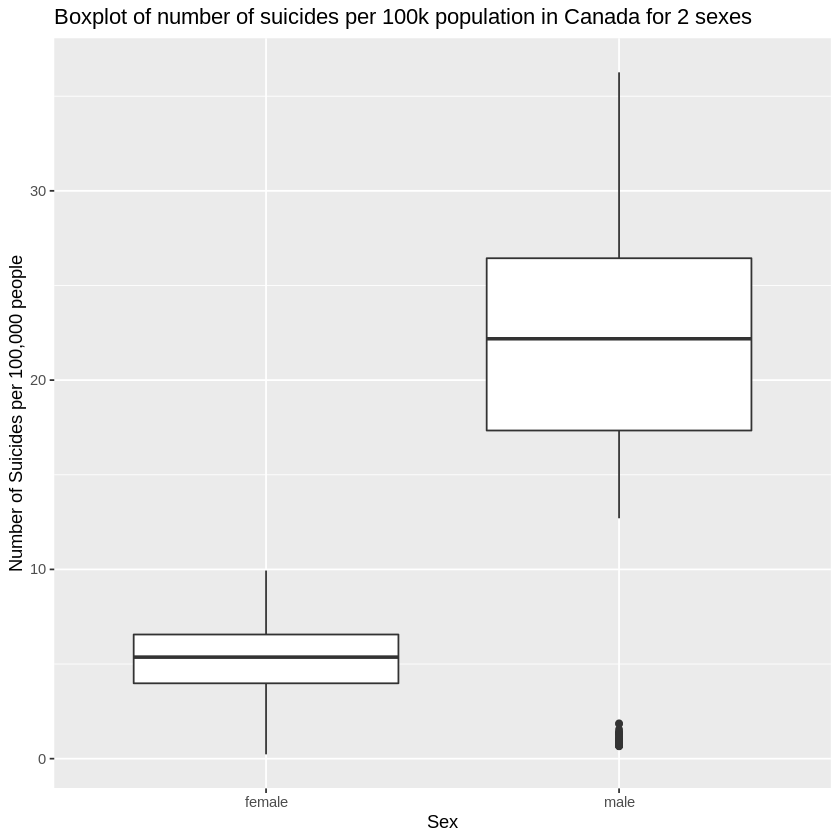

In [6]:
# plotting the boxplot of suicides per 100k population for males and females
boxplot <- suicide_sample %>%
    ggplot(aes(sex, suicides.100k.pop)) + 
    geom_boxplot() +
    ggtitle("Boxplot of number of suicides per 100k population in Canada for 2 sexes") +
    xlab("Sex") +
    ylab("Number of Suicides per 100,000 people")
boxplot

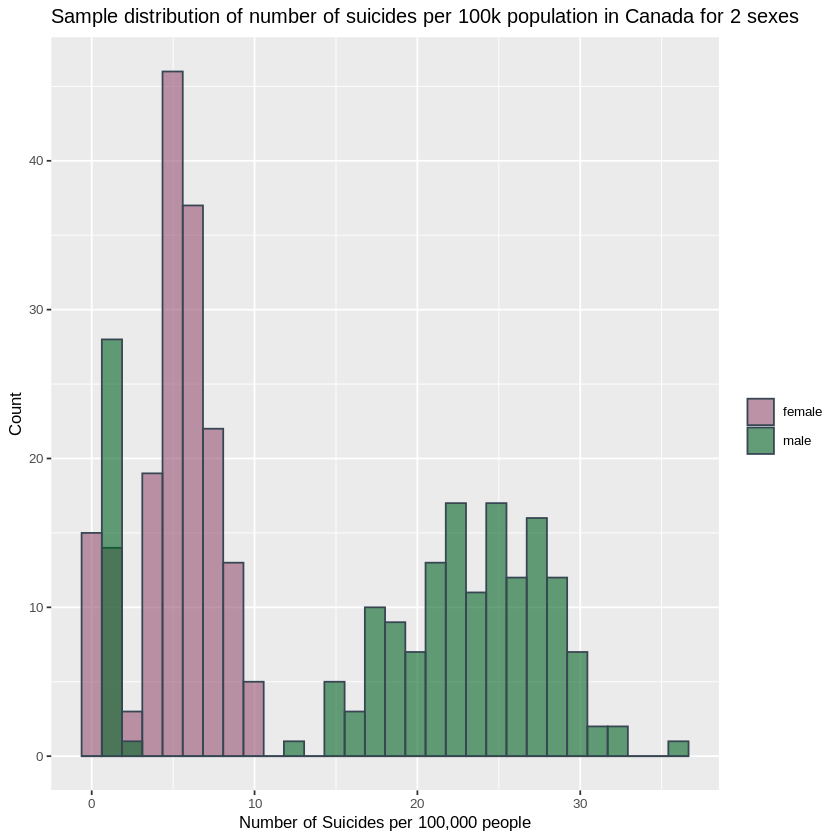

In [7]:
# plotting the sample distribution of suicides per 100k population for males and females
histogram <- suicide_sample %>%
    ggplot(aes(x = suicides.100k.pop, fill = sex)) +
    geom_histogram(bins=30, color="#374652", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#985473", "#036425")) +
    ggtitle("Sample distribution of number of suicides per 100k population in Canada for 2 sexes")+
    xlab("Number of Suicides per 100,000 people") +
    ylab("Count") +
    labs(fill="") +
    theme(text = element_text(size = 10))
histogram

The following is the summary statistics (sample means of suicide rates for females and males). We can clearly see that the mean suicide rates of males is higher than females. 

In [8]:
# calculating the point estimates from our sample for the 2 population groups, that is 
# calculating the mean suicide rates for males and females in Canada
summary <- suicide_sample%>%
        group_by(sex) %>%
        summarize(mean = mean(suicides.100k.pop))
summary

sex,mean
<chr>,<dbl>
female,5.113161
male,19.822011


#### Hypothesis testing
The essence of this report is to investivage if the mean suicide rates of males are more than the mean suicide rates of females in Canada. Hence, our null hypothesis will be assuming that they are indeed less than or equal. The null and alternate hypothesis are hence: 
- $H_0: \mu_m - \mu_f \le 0$ 
- $H_1: \mu_m - \mu_f > 0$

(where $\mu_m$ means the mean suicide rates of males and $\mu_f$ means the mean suicide rates of females. 

We will be conducting hypothesis tests with a significance level of $5\%$ ($\alpha = 0.05$). Moreover, since the alternate hypothesis has a not equal to sign, it will be a two sided hypothesis test. 

We investigate this using both bootstrap and asymptotic methods, however we first use the bootstrap method. 

**Bootstrap Method**

We use the infer package to form the bootstrap distribution for the difference of means in suicide rates between males and females. We take 1000 bootstrap samples since this ensures a high degree of accuracy while also giving a good enough computation time. Increasing the number of repetitions further would simply lead to a more extensive computation without giving better results or accuracy (any benefits would be marginal). <br>
Additionally, the order of calculating the difference doesn't matter but we subtract the mean of females from the mean of males just for correspondance. 

In [20]:
# setting seed to ensure reproducibility
set.seed(123)
# take 1000 bootstrap samples and calculate the difference in means for each sample
bootstrap_dist <- 
    suicide_sample %>% 
    specify(formula = suicides.100k.pop ~ sex) %>% # suicides per 100k population is set as the response variance and 
                                                   # sex is set as the explanatory variable
    generate(reps = 1000, type = "bootstrap") %>% # generating 1000 bootstrap samples 
    calculate(stat = "diff in means", order = c("male", "female")) # calculating the difference in means
head(bootstrap_dist)

replicate,stat
<int>,<dbl>
1,15.85483
2,13.85279
3,14.11451
4,13.23332
5,14.50301
6,15.92671


Next we calculate the observed test statistic of our sample. This is simply the difference in suicide rates which we observe in the real world in our sample, under no influence of the null hypothesis. 

In [22]:
# calculate the observed test statistic
obs_test_stat <- suicide_sample %>% 
        specify(formula = suicides.100k.pop ~ sex) %>% # suicides per 100k population is set as the response variance 
                                                       # and sex is set as the explanatory variable
        calculate(stat = "diff in means", order = c("male", "female")) %>%
        pull()
cat("The observed difference of means is", obs_test_stat)

The observed difference of means is 14.70885

Now, we simply plot the observed test statistic over the bootstrap distribution of our sample. This gives us an idea of the reliability of the test statistic. 

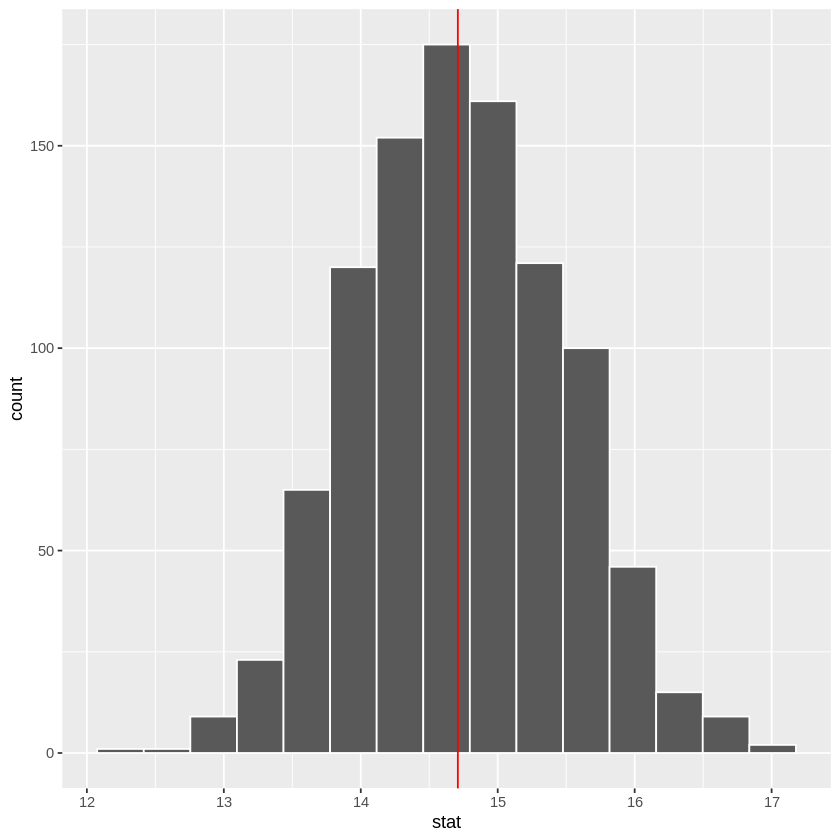

In [24]:
# plot the bootstrap distribution with a red vertical line indicating the observed test statistic
bootstrap_dist_plot <-
    bootstrap_dist %>%
    ggplot() +
    geom_histogram(aes(x=stat), bins = 15, color="white") +
    geom_vline(xintercept = obs_test_stat, color = "red") 
bootstrap_dist_plot

Next, we form the null distribution. This is bootstrap distribution of the sample under the null hypothesis. We adjust all the values to have the center of the distribution to be at 0 since our predicted difference of means is less than or equal to 0. 

In [25]:
# adjust the center of our bootstrap distribution to 0 and call it null_dist
null_dist <- 
     bootstrap_dist %>%
     mutate(stat=stat-(obs_test_stat-0))
head(null_dist)

replicate,stat
<int>,<dbl>
1,1.1459803
2,-0.8560590
3,-0.5943426
4,-1.4755307
5,-0.2058419
6,1.2178606


Below is a plot of the null distribution with a red vertical line plotted at the observed test statistic value. This helps us visualize an estimate of how probable observing this test statistic is if null hypothesis holds (essentially helps us predicted the $p$-value)  

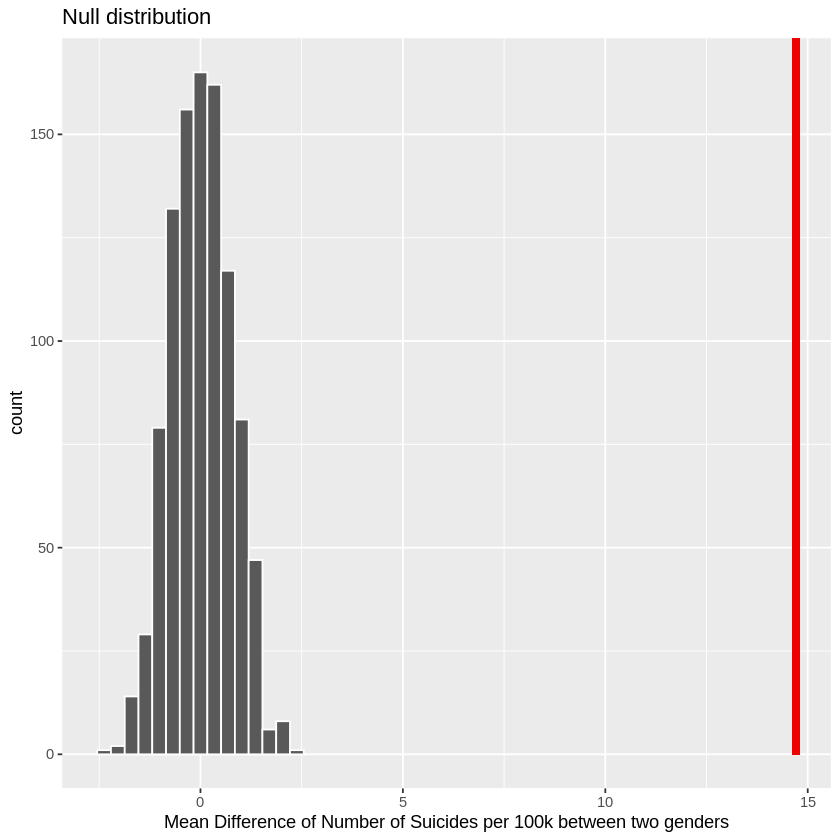

In [26]:
# visualize the null distribution with a vertical line indicating the observed test statistic
visualize_null_dist_p <- 
    visualize(null_dist) + 
    shade_p_value(obs_stat = obs_test_stat, direction = "right") +
    xlab("Mean Difference of Number of Suicides per 100k between two genders") +
    ggtitle("Null distribution")
visualize_null_dist_p

As we can clearly see in the graph above, the observed test statistic is quite far away from the null distribution, therefore, it seems highly unlikely that we observe this value when the difference if means is 0. To solidify this, we calculate the $p$-value explicitly. <br>
We use the `get_p_value` function from the `infer` package, and set the `direction` argument to be "right" since our alternate hypothesis is $H_1: \mu_m - \mu_f > 0$

In [30]:
# compute the p-value

pvalue <- 
    null_dist %>% 
    get_p_value(obs_stat = obs_test_stat, direction = "right") |>
    pull()
cat("p-value is", pvalue)

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p-value is 0

The $p$-value seems to be 0 but we should never report it to be 0 as it suggests that it is impossible to make Type I error. Instead, since we are using 1000 bootstrap repitions, we report the next smallest $p$-value possible is that $p$-value $<$ 0.001

This gives us a strong enough reason to report the conclusion of our hypothesis test. <br>

**Given that p-value < 0.001 < 0.05, we reject the null hypothesis at 5% significance level.**

This gives us a strong conclusion which is in line with our predictions from the prilimary results section and previous studies. However, to strengthen this argument, we also form a 90% confidence interval. 

We use the `get_ci` function to simplify this process and use the sample boostrap distribution which we generated in the section above. 

In [31]:
# calculting the 90% confidence interval for our bootstrap distribution
confidence_interval <- bootstrap_dist %>%
    get_ci(level = 0.90, type = "percentile")
confidence_interval

lower_ci,upper_ci
<dbl>,<dbl>
13.54918,15.94303


The lower limit is 13.55 and the upper limit is 15.94. This means we can be 90% confident that our true difference of means is captured by this interval ($13.55 \le \mu_m - \mu_f \le 15.94$). That is, of all the confidence intervals that could be calculated, around 90% of them would contain/capture the true difference of means of suicide rates between males and females.  

We have also plotted this confidence interval on the distribution below. 

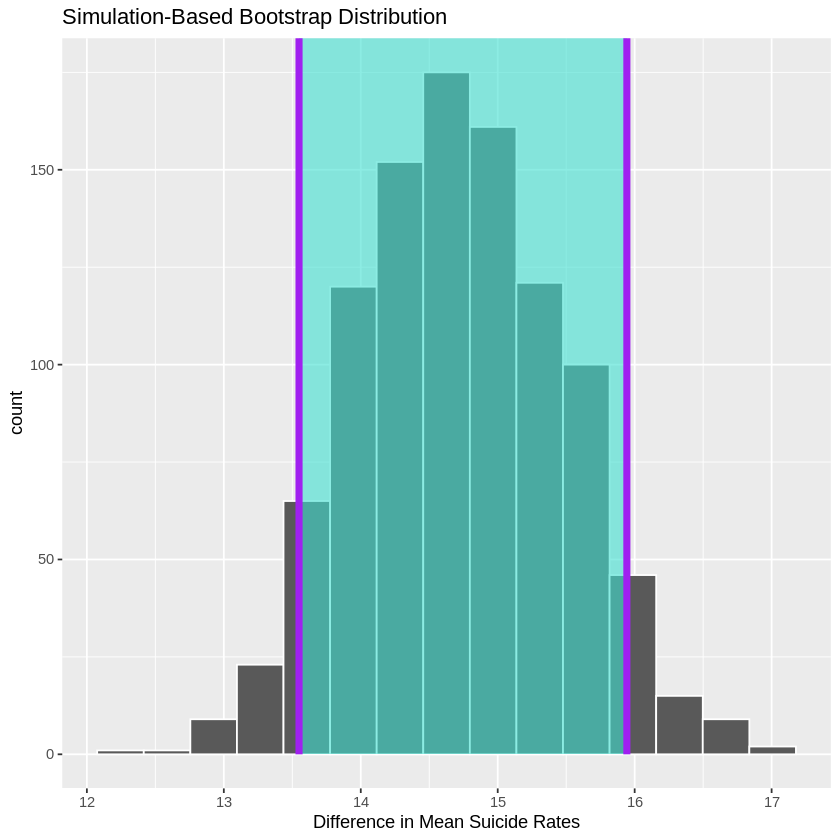

In [32]:
# plotting and shading the confidence interval on the bootstrap distribution. 
confidence_interval_plot <- bootstrap_dist |>
    visualise() +
    shade_ci(endpoints = confidence_interval, color = "purple") + 
    xlab("Difference in Mean Suicide Rates")

confidence_interval_plot

Hence, we can quite confidently say that the null hypothesis can be rejected in this case since even the limits of the confidence interval don't seem to be anywhere close to 0. However, in order to give a proper result report to the stakeholders, we want to be as sure as possible. Therefore, we confirm our simulation based results using theory based methods. 

**Asymptotic Method**

In [17]:
# use built-in method t.test in R to conduct a two sample t test 
test_summary <- tidy(
        t.test(x = suicide_sample%>% 
                   filter(sex == "male") %>%
                   pull(suicides.100k.pop),
               y = suicide_sample%>% 
                   filter(sex == "female") %>%
                   pull(suicides.100k.pop),
               alternative = "greater"))
test_summary

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
14.70885,19.82201,5.113161,20.11646,5.37673e-50,197.4708,13.50049,Inf,Welch Two Sample t-test,greater


#### Methods: Plan

This report compares the differences of suicide rate in Canada from 1985 and 2013, it focuses on the gender and has a wide time period ranging from 1985 to 2013. It’s trustworthy because the hypothesis is tested in a straightforward way of deriving estimates. Plus, the sample we are using is relatively large so the result we get will be reliable. However, if we don’t use the bootstrapping method and the asymptotic analysis to verify the hypothesis, the result we get would be susceptible to outliers or other facts.

Even though we clearly see a difference in the mean suicide rates (males showing much higher suicde rates than females) we cannot yet be certain about whether this difference is because of actual distinction between the suicide rates or if its simply a result of sampling variation. Hence, we will be using hypothesis tests to get better more reliable conclusion to our question. We expect to find the extent to which the suicide rates vary between males and females in Canada using their mean and standard deviation. Our prediction is that males do have higher suicide rates then females as can be seen in our priliminary results and previous research studies (Freeman et al., 2017).

However, this report is only a proposal, the final report will dive into many more details and give more concrete answers to the question which are less prone to erroneous interpretations using confidence intervals and hypothesis tests. An impact of actually finding a difference in suicide rates could help in focusing extra resources in studying the causes of such differences and possibly mitigating them to avoid loss of life. Henceforth, some future questions which this could lead to are: What are the causes of this difference in suicide rates? What can be done to avoid so many more males from committing suicide? 

### Discussion

We found that the mean suicide rates of males are higher than that of females in Canada between 1985 and 2013.......
,bFrom this report, there is an obvious difference between males and females in suicide rates. Knowing the fact of that, experts may get into a deeper perspective of the factors that caused high suicide rates among males and then break them down into different age groups to examine the specific suicidal ideation and behaviors. Afterward, organizations and non-government agencies, international institutions, and other policymakers are possible to drive changes and prevention efforts. Linkages with databanks related to other environments of public health interest (e.g., health records, schools, corrective services, drug and alcohol services) should then be encouraged for public health and research purposes (De Leo, 2015).  If we have a shared database and sufficient analysis of the suicide rates in different countries, it is likely that the loss of life will be minimized.


### References

1. Rusty. “Suicide Rates Overview 1985 to 2016e.” Kaggle, 1 Dec. 2018, https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016.   

2. Freeman, Aislinné et al. “A Cross-National Study on Gender Differences in Suicide Intent - BMC Psychiatry.” BioMed Central, BioMed Central, 29 June 2017, https://bmcpsychiatry.biomedcentral.com/articles/10.1186/s12888-017-1398-8.  

3. Elflein, John. “Distribution of Deaths Canada by Cause 2020.” Statista, 4 Mar. 2022, https://www.statista.com/statistics/437880/proportion-of-deaths-in-canada-by-disease/#:~:text=However%2C%20the%20leading%20causes%20of,43.9%20percent%20of%20all%20deaths.   

4. Leo, D. D. (2015, February). Can we rely on suicide mortality data? - researchgate.net. ResearchGate. Retrieved November 22, 2022, from https://www.researchgate.net/profile/Diego-De-Leo/publication/272081185_Can_We_Rely_on_Suicide_Mortality_Data/links/5609201208ae13969149c8d6/Can-We-Rely-on-Suicide-Mortality-Data.pdf 